### Collecting data

In [75]:
import re

import string

def clean_and_tokenize(inp: str, only_clean: bool = False) -> list:

    # maps (replaces) each punctuation to " "
    inp = inp.translate(str.maketrans(string.punctuation, " "*len(string.punctuation)))

    # replaces multi-spaces with " "
    inp = re.sub(r'\s+', ' ', inp.lower())

    return inp if only_clean else inp.split()

text = '''Machine learning is the study of computer algorithms that \
improve automatically through experience. It is seen as a \
subset of artificial intelligence. Machine learning algorithms \
build a mathematical model based on sample data, known as \
training data, in order to make predictions or decisions without \
being explicitly programmed to do so. Machine learning algorithms \
are used in a wide variety of applications, such as email filtering \
and computer vision, where it is difficult or infeasible to develop \
conventional algorithms to perform the needed tasks.'''
text2 = '''
a man and a woman received mostly positive reviews gender identity refers to an individual personal sense of identity as man or              
 woman man and woman arrested after male attacked a man and a woman both aged in their thirty in nature man and woman i examine the               
 representation of men and women by focussing on the grammatical behaviour of the noun lemmas man and woman examined the frequency with               
 the words man men and woman women bachelor and spinster extend to basic terms for male and female human beings she looked at man woman               
 and boy girl and found that negative words are used more frequently with woman girl than with man boy the four directions are the               
 directions north east south and west appears to rotate around an axis passing through the north and south poles of the earth in these               
 locations whether the sun is moving from east to west through north or south by watching its movements the sun rises either north or               
 south of true east and sets north or south of true west for all locations the sun is seen to rise north of east and set north of west               
 analogue watch can be used to locate north and south this axis intersects the sphere at the north and south poles which appear to the               
 observer to lie directly above due north and south respectively on the horizon morning precedes afternoon evening and night in the               
 sequence of a day also true for evening and night night or nighttime is the period of darkness from sunset to sunrise unlike good               
 morning good afternoon and good evening good night is not used as a greeting what are the time ranges for morning afternoon evening               
 night and do they change with location or the seasons empire was ruled by an emperor king an emperor was also king grand prince was               
 reserved for an emperor or king grand prince in some languages is title before emperor and king start with the king or queen despite               
 they were an emperor or empress a queen regnant is a female monarch equivalent in rank to a king at the top of the hierarchy of royal               
 titles is the king and queen the relatives of the king and queen known as prince and princess only last royal titles work what the king               
 and queen actually do prince became a king a prince the male child of the king limited palette consisting of red yellow black and white               
 a mixture of yellow and black will appear as a variety of green basic colors include black white red green blue and yellow set of twelve               
 lack gray white pink red orange yellow green blue nonspectral colors are the colors gray black and white the antonym of white is black               
 black and white also appealed to architects tied with black and white black and white often represent the contrast between light and               
 darkness day and night male and female calendar are generally recognized spring summer autumn or fall and winter four seasons winter               
 spring summer autumn fall in the middle of summer and winter number of seasons between summer and winter can number from one to three               
 universally translated as spring summer autumn and winter but actually begin much earlier autumn is the season between summer and winter               
 lasting from march to june or from september to december summer is the season between spring and autumn from june to september or from               
 december to march winter spring summer and autumn are the seasons of the year december january and february are the winter months march               
 april and may are the spring months june july and august are the summer months day to learn about days weeks months and years twelve months               
 make year seven days make week days fit into a week into a month and into a year each new day starts at midnight days in some months to make               
 them all add up to one year
'''
tokens = clean_and_tokenize(text2)
len(tokens)

664

In [76]:
def build_dict(tokens:list) -> tuple[dict,dict]:
    word2idx = {}
    cur_index = 0
    for i, t in enumerate(tokens):
        if t not in word2idx.keys():
            word2idx[t] = cur_index
            cur_index += 1
    idx2word = {v: k for k, v in word2idx.items()}
    return word2idx, idx2word

w2i, i2w = build_dict(tokens)
list(w2i.items())[:6]

[('a', 0),
 ('man', 1),
 ('and', 2),
 ('woman', 3),
 ('received', 4),
 ('mostly', 5)]

### Creating a training set
Originally we have a set of tokens $\{t_1,t_2,t_3,...,t_N\}$. We convert this data into a trainable format i.e. $\{(t_2, t_1), (t_2, t_3), ...\}$, where the first element would be $x$ and the second - $y$. Hence our learning task will be related to predicting a neighbouring word inside some n-gram window based on the input token. This type of word2vec model is also refered as **skip-gram**.

In [77]:
import numpy as np


def ohe(token_idx: int, dict_size: int):
    # one-hot single vector encoding
    return [0 if i != token_idx else 1 for i in range(dict_size)]

def concat(*iterables):
    for iterable in iterables:
        yield from iterable

def generate_training_data(tokens: list, word2idx: dict, window: int):
    X = []
    y = []
    n_tokens = len(tokens)
    
    for i in range(n_tokens):
        idx = concat(
            range(max(0, i - window), i), 
            range(i, min(n_tokens, i + window + 1))
        )
        for j in idx:
            if i == j:
                continue # skipping this step in a loop
            X.append(ohe(word2idx[tokens[i]], len(word2idx)))
            y.append(ohe(word2idx[tokens[j]], len(word2idx)))
    
    # asarray = array, but does not make a copy of it
    return np.asarray(X), np.asarray(y)

### Creating another variation of a training set
Instead of iterating over pairs we're going to sample minibatches of windows $(t_{i},t_{i+1},...,t_{\text{window\_size}})$ in order to get an extra average of a loss with respect to $\text{window\_size}$. Hence at the center of each window would be our observed token (our $x$) surrounded by neighbouring tokens on both sides (our targets $y$).

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

class windows_ds(Dataset):

    def __init__(self, tokens: list, word2idx: dict, window_size: int):
        super().__init__()
        self.tokens = torch.as_tensor([word2idx[t] for t in tokens])
        self.window_size = window_size
        self.padding = window_size // 2

    def __len__(self):
        return len(self.tokens)
    
    def __getitem__(self, index): 
        """
        :returns: x (token index), y (indices of neighbouring tokens)
        """
        if index >= len(self):
            raise IndexError   
        start = max(0, index - self.padding)
        end = min(len(self), index + self.padding + 1)

        if start == 0:
            end = min(len(self), start + self.window_size)
        elif end == len(self):
            start = max(0, end - self.window_size)
        
        return self.tokens[index], torch.cat([self.tokens[start:index],self.tokens[index+1:end]])
    
train_ds = windows_ds(tokens, w2i, 3)
train_ds[662]

(tensor(215), tensor([ 11, 229]))

In [84]:
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
next(iter(train_dl))

[tensor([119, 212,  73, 145,  31,   2,  63, 181]),
 tensor([[131,   2],
         [  2, 219],
         [  2,  74],
         [ 12,  18],
         [ 16,  40],
         [181, 182],
         [205, 206],
         [ 44,   2]])]

### Creating word2vec from scratch using only numpy

#### Forward pass
Our model architecture **could** be the following:
$X_{N\times V}\rightarrow Z_1=\text{ReLU}(A_1=X\times W^1_{V\times E})\rightarrow Z_2=\sigma(A_2=Z_1\times W^2_{E\times V})$, where:
* $N$ - batch size
* $V$ - vocabulary size
* $E$ - embedding dimensions
* $\sigma$ - softmax activation

#### **upd:**
However ReLU is a pretty challenging activation for a word2vec model, as it adds more non-linearity, which sparses out embeddings eventually making their quality worse than it could be. Hence, we're going to replace ReLU activation with another FC layer.

#### Backward pass
The most important thing I feel like is needed to be highlighted is that we're always looking at **one input row and NOT $N$**. 
##### Step 1: Calculating $\frac{\partial Z_2}{\partial A_2}$
Gradient varies if we're considering $i=j$ or $i\neq j$ cases, where $i$ and $j$ correspond to columns, i.e. different classes from $1$ to $C$:
* case $i=j$: 
    $$
        \frac{\partial}{\partial a^i_2}[\frac{exp(a^i_2)}{\sum^C_k exp(a^k_2)}]=\frac{exp(a^i_2)\sum^C_k exp(a^k_2)-exp^2(a^i_2)}{[\sum^C_k exp(a^k_2)]^2} = \\
        
        =\frac{exp(a^i_2)}{\sum^C_k exp(a^k_2)}(1-\frac{exp(a^i_2)}{\sum^C_k exp(a^k_2)})=z^i_2(1-z^i_2)
    $$
* case $i\neq j$:
    $$
        \frac{0-exp^2(a^j_2)exp^2(a^i_2)}{[\sum^C_k exp(a^k_2)]^2} = -z^i_2z^j_2
    $$

##### Step 2: Calculating $\frac{\partial L}{\partial A_2}$
For this problem we're going to use Cross Entropy loss: $L=-\sum_i^N y_i\log{p_i}$ (where $y$ and $p$ are vectors). This gradient is going to be shared across all updated parameters of the model, so it's the most crucial calculation of the whole backward pass:
$$
\frac{\partial L}{\partial A_2}=-\sum^C_k y_k\frac{\partial\log{z^k_2}}{\partial z^k_2}\times\frac{\partial z^k_2}{a^i_2}=\\

= y_i\frac{1}{z^i_2}\times z^i_2(1-z^i_2)+\sum^C_{k\neq i}y_k\frac{1}{z^k_2}z^i_2z^j_2=z^i_2y_i-y_i+\sum^C_{k\neq i}z^i_2y_k=\\

=z^i_2(\sum^C_{k\neq i}y_k + y_i)-y_i=z^i_2-y_i
$$
since $(\sum^C_{k\neq i}y_k + y_i)=1$, because $y$ is a onehot-encoded vector of probabilities that add up to $1$.

##### Step 3: Calculating $\frac{\partial L}{\partial W_2}$

1. First of all, $\frac{\partial A_2}{\partial W^j_2}=Z^i_1$, hence $\frac{\partial A_2}{\partial W_2}=Z^T_1$, which is of shape $E\times 1$
2. Our output shape of a gradient should be $E\times V$, therefore a proper matrix form of a chain rule would look like this: $\frac{\partial L}{\partial W_2}=\frac{\partial L}{\partial A_2}\frac{\partial A_2}{\partial W_2}=Z^T_1(Z_2-y)$

##### Step 4: Calculating $\frac{\partial L}{\partial W_1}$
Using a chain rule we write the gradient as $\frac{\partial L}{\partial A_2}\frac{\partial A_2}{\partial Z_1}\frac{\partial Z_1}{\partial A_1}\frac{\partial A_1}{\partial W_1}$
1. An arbitrary case of $\frac{\partial\text{ReLU}(x)}{\partial x}=I_{(0;\infty)}(x)$, where $I$ is an [indicator function](https://en.wikipedia.org/wiki/Indicator_function). Essentially, it assignes $0$ if $x\leq0$ and $1$ otherwise, thus zeroing out gradients under a specific condition. Therefore we can multiply this $\frac{\partial Z_1}{\partial A_1}$ with past gradients by using a simplier point-wise multiplication (refered as $\odot$)
2. Combining everything together a proper gradient calculation can be described as follows: $X^T(I_{(0;\infty)}(A_1)\odot[(Z_2-y)W^T_2])$

In [90]:
def softmax(z: np.ndarray):
    z = z - z.max(axis=1, keepdims=True)
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

def relu(x: np.ndarray):
    return np.maximum(0,x)

def accuracy(y_pred: np.ndarray, y_true: np.ndarray):
        return (np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1)).sum() / len(y_true)

def ce(y_pred: np.ndarray, y_true: np.ndarray):
    # cross-entropy loss
    return -np.sum(y_true*np.log(y_pred))

class optimizer:
    
    def __init__(self):
        pass

    def step(self):
        return NotImplementedError

class SGD_optimizer(optimizer):

    def __init__(self):
        super().__init__()

    def step(self, param: np.ndarray, grad: np.ndarray, lr: float):
        return param - lr * grad

class word2vec_lite_model_with_relu:
    
    def __init__(self, optim: optimizer, embed_dims: int, vocab_size: int, lr: float = 1e-3):
        self.W1 = np.random.randn(vocab_size, embed_dims)
        self.W2 = np.random.randn(embed_dims, vocab_size)
        self.dLdW1 = np.zeros_like(self.W1)
        self.dLdW2 = np.zeros_like(self.W2)
        self.losses = []
        self.accuracies = []
        self.lr = lr
        self.cache = {}

        # NOTE: training is only set up for SGD type optimizer
        self.optimizer = optim

    def forward(self, X, y=None):
        self.cache['f'] = X @ self.W1
        if y is not None:
            self.cache['z1'] = relu(self.cache['f'])
        else:
            self.cache['z1'] = self.cache['f']
        self.cache['g'] = self.cache['z1'] @ self.W2
        self.cache['z2'] = softmax(self.cache['g'])
        if y is not None:
            self.losses.append(ce(self.cache['z2'],y))
            self.accuracies.append(accuracy(self.cache['z2'],y))
        return self.cache['z2']

    def backward(self, X, y):
        dLdg = self.cache['z2'] - y
        self.dLdW2 = self.cache['z1'].T @ dLdg
        self.dz1df = np.where(self.cache['f'] <= 0, 0, 1)
        self.dLdW1 = X.T @ (self.dz1df * (dLdg @ self.W2.T))

    def update(self):
        self.W1 = self.optimizer.step(param=self.W1, grad=self.dLdW1, lr=self.lr)
        self.W2 = self.optimizer.step(param=self.W2, grad=self.dLdW2, lr=self.lr)

class word2vec_lite_model_only_fc:
    
    def __init__(self, optim: optimizer, embed_dims: int, hidden_dims: int, vocab_size: int, lr: float = 1e-3):
        self.W1 = np.random.randn(vocab_size, embed_dims)
        self.W2 = np.random.randn(embed_dims, vocab_size)
        self.dLdW1 = np.zeros_like(self.W1)
        self.dLdW2 = np.zeros_like(self.W2)
        self.losses = []
        self.accuracies = []
        self.lr = lr
        self.cache = {}
        self.optimizer = optim

    def forward(self, X, y=None):
        self.cache['a1'] = X @ self.W1
        self.cache['a2'] = self.cache['a1'] @ self.W2
        self.cache['z'] = softmax(self.cache['a2'])
        if y is not None:
            self.losses.append(ce(self.cache['z'],y))
            self.accuracies.append(accuracy(self.cache['z'],y))
        return self.cache['z']

    def backward(self, X, y):
        dLdg = self.cache['z'] - y
        self.dLdW2 = self.cache['a1'].T @ dLdg
        self.dLdW1 = X.T @ (dLdg @ self.W2.T)

    def update(self, grad_clip:bool=False):
        if grad_clip:
            self.dLdW1 = self.dLdW1.clip(-1,1)
            self.dLdW2 = self.dLdW2.clip(-1,1)
        self.W1 = self.optimizer.step(param=self.W1, grad=self.dLdW1, lr=self.lr)
        self.W2 = self.optimizer.step(param=self.W2, grad=self.dLdW2, lr=self.lr)

In [93]:
from tqdm.auto import tqdm
import wandb
import yaml
import os
import logging 


config = {
    'lr': 2e-3,
    'max_epochs': 1000,
    'vocab_size': len(w2i),
    'model': 'fc_fc_softmax',
    'data': 'text2 + fixed tokens',
    'grad_clipping': True,
    'embed_d': 256,
    'skipgram_window_size': 3,
    'hidden_d': 64,
}


LOGS_DIR = './logs'
RUN_VERSION = 31  # don't forget to change
LOG_PARAMS = True
LOG_WANDB = True
config['version'] = RUN_VERSION

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.DEBUG)
def log_run_params(run_version: int, config: dict) -> None:
    f_path = os.path.join(LOGS_DIR,f'run_v{run_version}.yml')
    with open(f_path, 'w') as outfile:
        yaml.dump(config, outfile, default_flow_style=False)
    logger.info(f'Saved params to {f_path}')


optimizer = SGD_optimizer()
model = word2vec_lite_model_only_fc(
    optim=optimizer,
    embed_dims=config['embed_d'],
    hidden_dims=config['hidden_d'],
    vocab_size=config['vocab_size'],
    lr=config['lr'],
)
config['optimizer'] = optimizer.__class__.__name__
X, y = generate_training_data(tokens, w2i, config['skipgram_window_size'])

if LOG_PARAMS:
    log_run_params(RUN_VERSION, config)
if LOG_WANDB:
    run = wandb.init(
        project='mipt_nlp_w2v',
        name=f'word2vec_v{RUN_VERSION}',
        config=config)
pbar = tqdm(range(0,config['max_epochs']))

for epoch in pbar:
    _ = model.forward(X, y)
    model.backward(X, y)
    model.update(grad_clip=config['grad_clipping'])
    pbar.set_postfix(epoch=epoch,loss=model.losses[-1],refresh=False)
    if LOG_WANDB:
        run.log({
            'epoch': epoch+1,
            'train_loss': model.losses[-1],
            'train_accuracy': model.accuracies[-1]
        })

if LOG_WANDB:
    run.finish()

DEBUG:git.cmd:Popen(['git', 'cat-file', '--batch-check'], cwd=c:\Users\turku\Documents\GitHub\mipt_nlp, stdin=<valid stream>, shell=False, universal_newlines=False)


100%|██████████| 1000/1000 [00:29<00:00, 34.30it/s, epoch=999, loss=1.15e+4]


epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█
train_accuracy,▁▂▃▃████████████████████████████████████
train_loss,█▅▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,1000
train_accuracy,0.13545
train_loss,11522.86726


### Evaluating training results of a custom word2vec 

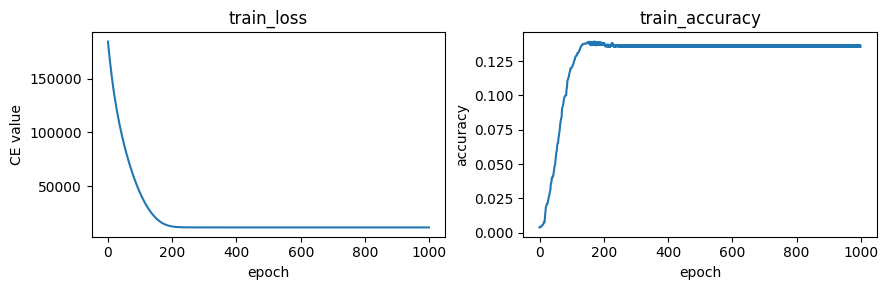

In [94]:
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)
logger.setLevel(logging.WARNING)

fig, axs = plt.subplots(1, 2, figsize=(9, 3))
axs[0].plot(list(range(0,config['max_epochs'])),model.losses)
axs[0].set(title='train_loss',xlabel='epoch',ylabel='CE value')
axs[1].plot(list(range(0,config['max_epochs'])),model.accuracies)
axs[1].set(title='train_accuracy',xlabel='epoch',ylabel='accuracy')
fig.tight_layout()

In [ ]:
# saving model locally

"""import pickle

model_pkl_file = f"./artifacts/w2v_v{RUN_VERSION}.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model, file)
    logger.info('successfully dumped the model')"""

### Initializing a simplier model using torch api
Replace two fully connected layers with a single embedding matrix, that we'll use as a lookup table.

In [104]:
import torch.nn as nn


class SkipGram(nn.Module):
    def __init__(self, vocab_size, embed_dims):
        super().__init__()
        self.embeds = nn.Embedding(vocab_size, embed_dims)

    def forward(self, center):
        return self.embeds(center)


def training_step(model_embed, x, y, optimizer):
    optimizer.zero_grad()
    
    # onehot encoding distribution
    y_hat = torch.zeros((len(y), model_embed.embeds.weight.shape[0]))
    for i, obs in enumerate(y):
        y_hat[i, obs] = 1.0

    inp_embed = model_embed(x)
    out = nn.LogSoftmax(dim=-1)(inp_embed @ model_embed.embeds.weight.T)
    loss = -(out*y_hat).mean()
    loss.backward()
    optimizer.step()

    return loss


# reconfiguring params
RUN_VERSION += 1
config['version'] = RUN_VERSION
config['max_epochs'] = 500
config['embed_d'] = 256
config['model'] = 'embed_torch'
config['data'] = 'text2_minibatched_shuffled'
config['lr'] = 5e-4
torch_model = SkipGram(config['vocab_size'],config['embed_d'])  # model init
optimizer = torch.optim.Adam(torch_model.parameters(),lr=config['lr'])  # optimizer init
config['optimizer'] = optimizer.__class__.__name__

if LOG_PARAMS:
    log_run_params(RUN_VERSION, config)
if LOG_WANDB:
    run = wandb.init(
        project='mipt_nlp_w2v',
        name=f'word2vec_v{RUN_VERSION}_pytorch',
        config=config)

# training
pbar = tqdm(range(0,config['max_epochs']))
av_losses = []
for epoch in pbar:
    losses = []
    for x, y in train_dl:
        loss = training_step(torch_model, x, y, optimizer)
        losses.append(loss)
    av_losses.append(sum(losses) / len(losses))
    pbar.set_postfix(epoch=epoch,av_loss=av_losses[-1],refresh=False)
    if LOG_WANDB:
        run.log({
            'epoch': epoch+1,
            'train_av_loss': av_losses[-1]
        })

if LOG_WANDB:
    run.finish()

100%|██████████| 500/500 [00:56<00:00,  8.84it/s, av_loss=tensor(0.0254, grad_fn=<DivBackward0>), epoch=499]


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇███
train_av_loss,██▇▆▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,500
train_av_loss,0.0254


### Evaluating training results of a simplier model

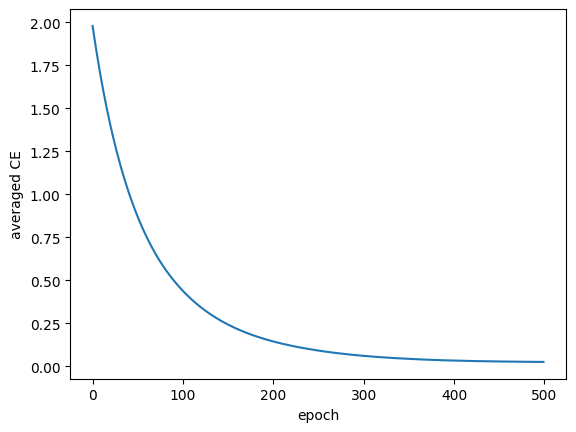

In [105]:
plt.plot(list(range(config['max_epochs'])), list(map(lambda x: x.item(), av_losses)))
plt.xlabel('epoch')
plt.ylabel('averaged CE')
plt.show()

### Look at different training iterations on wandb dashboard

In [15]:
from IPython.display import IFrame

wandb_report_url = 'https://api.wandb.ai/links/turkunov/f06f0bla'
IFrame(src=wandb_report_url, width=960, height=512)

### Playing around with embeddings
We're going to try extracting word embeddings as well as find closest candidates to a specific token

In [ ]:
import pickle

# loading the model of version {RUN_VERSION}
"""RUN_VERSION = 8
model_pkl_file = f"./artifacts/w2v_v{RUN_VERSION}.pkl"  
with open(model_pkl_file, 'rb') as file:  
    model = pickle.load(file)"""

def find_closest_custom(model, word: str, w2i: dict, i2w: dict, k: int = 10) -> list:
    word_input = np.array([ohe(w2i[word], len(w2i))])
    candidates = model.forward(word_input).argsort()[0][::-1]
    return list(map(lambda i: i2w[i], candidates[:k]))

def generate_embedding_custom(model, word: str, w2i: dict) -> np.ndarray:
    word_input = np.array([ohe(w2i[word], len(w2i))])
    _ = model.forward(word_input)
    print(model.cache['a1'].shape)
    return model.cache['a1']

def generate_embedding_torch(model: nn.Module, word: str, w2i: dict) -> torch.Tensor:
    model.eval()
    embed = model(torch.as_tensor(w2i[word]).long()).cpu()
    model.train()
    return embed

In [107]:
def l2(x: np.ndarray, y: np.ndarray) -> float:
    return np.sum((x-y)**2)**.5

def cos_dist(x: np.ndarray, y: np.ndarray) -> float:
    return 1 - (x*y).sum() / ((x**2).sum() * (y**2).sum()) ** .5

pairs = [('man','boy'),('man','spring')]
for t1, t2 in pairs:
    emb1, emb2 = generate_embedding_torch(torch_model,t1,w2i), generate_embedding_torch(torch_model,t2,w2i)
    print(f'{t1} VS {t2} :: {cos_dist(emb1, emb2)}')

man VS boy :: 0.08135592937469482
man VS spring :: 0.23882758617401123


### Placing the best model inside `solution.py` 

In [ ]:
from solution import train
import re
import string

def clean_and_tokenize(inp: str, only_clean: bool = False) -> list: 

    # maps (replaces) each punctuation to " "
    inp = inp.translate(str.maketrans(string.punctuation, " "*len(string.punctuation)))

    # replaces multi-spaces with " "
    inp = re.sub(r'\s+', ' ', inp.lower())

    return inp if only_clean else inp.split()

word2vec_dict = train(clean_and_tokenize(text2,only_clean=True))

100%|██████████| 1000/1000 [01:48<00:00,  9.21it/s, av_loss=tensor(0.0233, grad_fn=<DivBackward0>), epoch=999]


In [ ]:
def l2(x: torch.Tensor, y: torch.Tensor) -> float:
    return torch.sum((x-y)**2)**.5

def cos_dist(x: torch.Tensor, y: torch.Tensor) -> float:
    return 1 - (x*y).sum() / ((x**2).sum() * (y**2).sum()) ** .5

pairs = [('man','boy'),('man','girl')]
for t1, t2 in pairs:
    emb1, emb2 = word2vec_dict[t1], word2vec_dict[t2]
    print(f'{t1} VS {t2} :: {cos_dist(emb1, emb2)}')

man VS boy :: 0.06856048107147217
man VS girl :: 0.11991536617279053


### Conclusions
* Activations affect model's performance significantly
* More layers damage model's learning cabilities (loss curve becomes more noisy)
* Shuffled minibatches of windows work better than pairs taken from consecutive windows. Training is more stable.